# Model Training và Testing Pipeline

Notebook này thực hiện:
1. Load preprocessed data từ notebook 01
2. Test pipeline với một vài mô hình nhỏ để verify
3. Train các ensemble models (sẽ được hoàn thiện sau)


In [4]:
import sys
from pathlib import Path

# Xác định project root một cách linh hoạt (chạy từ root hoặc từ thư mục notebooks đều được)
current_dir = Path.cwd()
project_root = current_dir

# Nếu đang ở project root (có thư mục src ở hiện tại)
if (current_dir / 'src').exists():
    project_root = current_dir
# Nếu đang ở thư mục notebooks (thư mục cha có src)
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
# Fallback: giữ nguyên current_dir
else:
    project_root = current_dir

# Add project root vào PYTHONPATH
project_root_str = str(project_root.absolute())
if project_root_str not in sys.path:
    sys.path.insert(0, project_root_str)

print("Project root:", project_root)


Project root: d:\Code\credit_fraud_detection


In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.evaluate import evaluate_model, get_metrics_dict, print_metrics

# Import data preprocessing functions
from src.data_preprocessing import scale_features, split_data, get_class_weights

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print(f"Project root: {project_root.absolute()}")
print("Libraries imported successfully!")


Project root: d:\Code\credit_fraud_detection
Libraries imported successfully!


## 1. Load Preprocessed Data

Load dữ liệu đã được preprocess từ notebook 01. 
**Lưu ý**: Cần chạy notebook 01 trước để có dữ liệu đã preprocess.


In [6]:
# Load preprocessed data
# Note: In a real scenario, you would load the preprocessed data from notebook 01
# For testing, we'll reload and preprocess the data here

data_path = project_root / 'data' / 'creditcard.csv'
df = pd.read_csv(data_path)

# Prepare features and target
feature_cols = [f'V{i}' for i in range(1, 29)] + ['Amount']
X = df[feature_cols]
y = df['Class']

print(f"Data loaded: {X.shape[0]:,} samples, {X.shape[1]} features")
print(f"Class distribution: {y.value_counts().to_dict()}")


Data loaded: 284,807 samples, 29 features
Class distribution: {0: 284315, 1: 492}


In [7]:
# Scale features
X_scaled, scaler = scale_features(X, feature_cols=feature_cols, fit=True)

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X_scaled, y, 
    test_size=0.15, 
    val_size=0.15, 
    random_state=42
)

print("Data preprocessing completed!")
print(f"Train: {X_train.shape[0]:,} samples")
print(f"Validation: {X_val.shape[0]:,} samples")
print(f"Test: {X_test.shape[0]:,} samples")


Data preprocessing completed!
Train: 199,364 samples
Validation: 42,721 samples
Test: 42,722 samples


## 2. Test Pipeline với Mô hình Nhỏ

Test pipeline với Logistic Regression và Random Forest nhỏ để verify mọi thứ hoạt động đúng.


Testing Logistic Regression with class weights
Class weights: {np.int64(0): np.float64(0.5008642347502763), np.int64(1): np.float64(289.7732558139535)}

Metrics for Logistic Regression
Accuracy:  0.9777
Precision: 0.0669
Recall:    0.9189
F1 Score:  0.1248
AUC:       0.9856



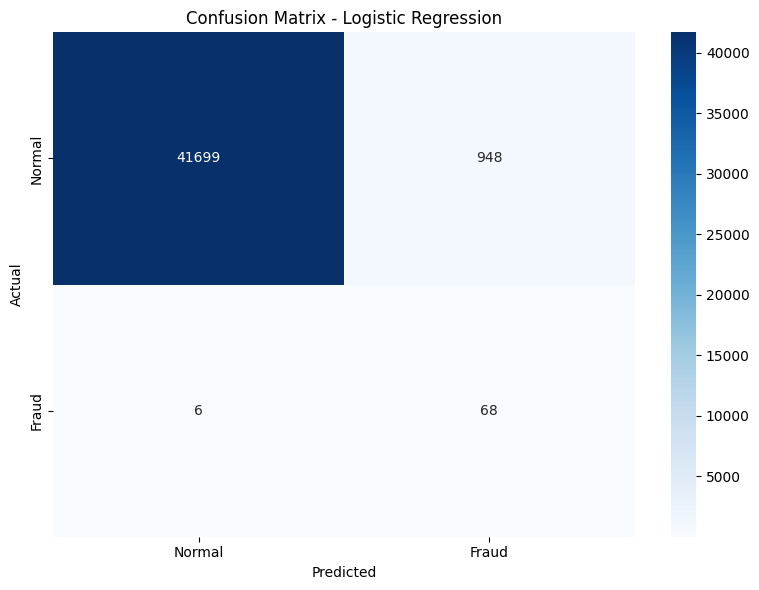

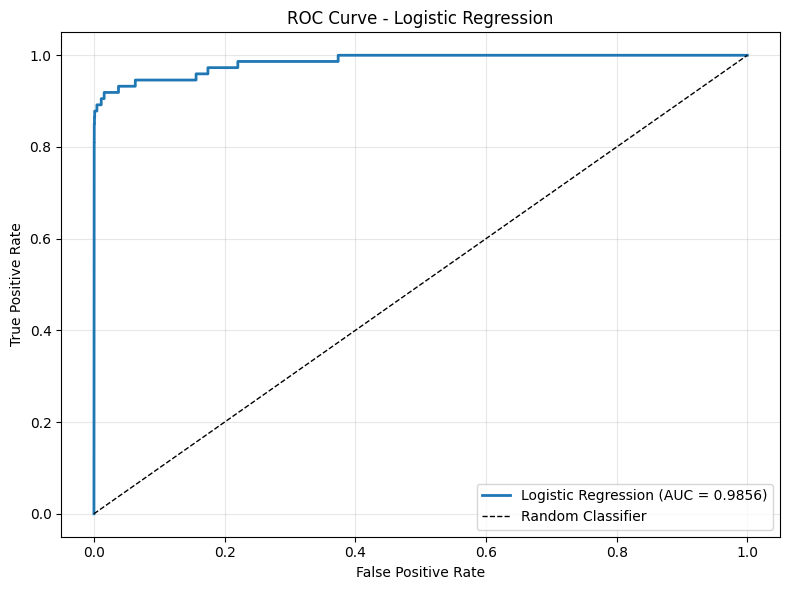

In [8]:
# Test 1: Logistic Regression với class weights
print("="*60)
print("Testing Logistic Regression with class weights")
print("="*60)

# Get class weights
class_weights = get_class_weights(y_train)
print(f"Class weights: {class_weights}")

# Train model
lr_model = LogisticRegression(
    class_weight=class_weights,
    random_state=42,
    max_iter=1000
)
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_val)
y_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]

# Evaluate
metrics_lr, figures_lr = evaluate_model(
    y_val, y_pred_lr, y_pred_proba_lr,
    model_name='Logistic Regression',
    plot_cm=True,
    plot_roc=True
)


Testing Random Forest (small)

Metrics for Random Forest
Accuracy:  0.9994
Precision: 0.8451
Recall:    0.8108
F1 Score:  0.8276
AUC:       0.9668



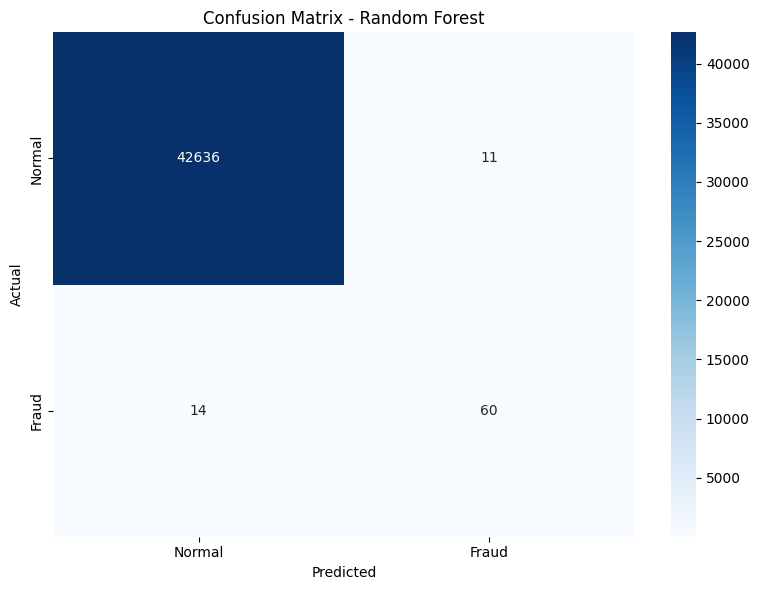

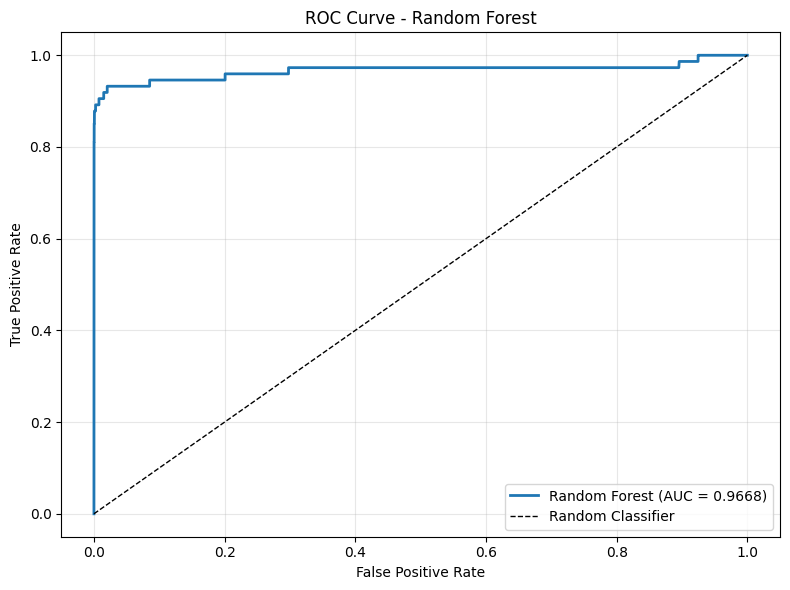

In [9]:
# Test 2: Random Forest nhỏ
print("="*60)
print("Testing Random Forest (small)")
print("="*60)

# Train model
rf_model = RandomForestClassifier(
    n_estimators=50,  # Small for testing
    max_depth=10,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Evaluate
metrics_rf, figures_rf = evaluate_model(
    y_val, y_pred_rf, y_pred_proba_rf,
    model_name='Random Forest',
    plot_cm=True,
    plot_roc=True
)


## 3. Verify Pipeline Hoạt động

Kiểm tra xem pipeline có hoạt động đúng không.


In [10]:
# Collect metrics for comparison
test_metrics = [
    get_metrics_dict(y_val, y_pred_lr, y_pred_proba_lr, 'Logistic Regression'),
    get_metrics_dict(y_val, y_pred_rf, y_pred_proba_rf, 'Random Forest')
]

# Create comparison DataFrame
comparison_df = pd.DataFrame(test_metrics)
print("\n" + "="*60)
print("Pipeline Test Results - Metrics Comparison")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

print("\n✅ Pipeline test completed successfully!")
print("✅ All models trained and evaluated correctly")
print("✅ Evaluation functions working properly")
print("\nNext steps: Train full ensemble models (Random Forest, AdaBoost, XGBoost)")



Pipeline Test Results - Metrics Comparison
 accuracy  precision   recall       f1      auc               model
 0.977669   0.066929 0.918919 0.124771 0.985581 Logistic Regression
 0.999415   0.845070 0.810811 0.827586 0.966830       Random Forest

✅ Pipeline test completed successfully!
✅ All models trained and evaluated correctly
✅ Evaluation functions working properly

Next steps: Train full ensemble models (Random Forest, AdaBoost, XGBoost)


## 4. Train các Ensemble Models đầy đủ

Train 3 ensemble models: Random Forest, AdaBoost, XGBoost với parameters tối ưu.


In [11]:
# Import model training functions
from pathlib import Path
from src.models import (
    train_random_forest, train_adaboost, train_xgboost,
    save_model, load_model, evaluate_model_performance
)

# Thư mục lưu model
models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)

def _model_path(model_name: str) -> Path:
    filename = model_name.lower().replace(' ', '_') + '.pkl'
    return models_dir / filename

def load_or_train(model_name: str, train_fn, *args, **kwargs):
    """Load model nếu đã tồn tại trong models/, nếu không thì train rồi save."""
    model_path = _model_path(model_name)
    if model_path.exists():
        print(f"⏭️ Skip train: found {model_path.name}")
        return load_model(model_name, model_dir=models_dir), False

    model = train_fn(*args, **kwargs)
    save_model(model, model_name, save_dir=models_dir)
    return model, True

# Dictionary to store all models and results
trained_models = {}
model_predictions = {}
model_probabilities = {}


### 4.1 Train Random Forest


In [12]:
# Load hoặc train Random Forest (nếu đã có model trong models/ thì skip train)
rf_model, _ = load_or_train(
    'Random Forest',
    train_random_forest,
    X_train, y_train,
    n_estimators=200,
    max_depth=15,
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1,
)

# Predictions on validation set
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Store results
trained_models['Random Forest'] = rf_model
model_predictions['Random Forest'] = y_pred_rf
model_probabilities['Random Forest'] = y_pred_proba_rf

# Evaluate
evaluate_model_performance(rf_model, X_val, y_val, 'Random Forest')


🔹 Training Random Forest model...
   Parameters: n_estimators=200, max_depth=15
✅ Random Forest training completed!
✅ Model saved to d:\Code\credit_fraud_detection\models\random_forest.pkl

Evaluation Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.92      0.81      0.86        74

    accuracy                           1.00     42721
   macro avg       0.96      0.91      0.93     42721
weighted avg       1.00      1.00      1.00     42721



array([0, 0, 0, ..., 0, 0, 0], shape=(42721,))

### 4.2 Train AdaBoost


In [13]:
# Load hoặc train AdaBoost (nếu đã có model trong models/ thì skip train)
ada_model, _ = load_or_train(
    'AdaBoost',
    train_adaboost,
    X_train, y_train,
    n_estimators=100,
    learning_rate=0.5,
    random_state=42,
)

# Predictions on validation set
y_pred_ada = ada_model.predict(X_val)
y_pred_proba_ada = ada_model.predict_proba(X_val)[:, 1]

# Store results
trained_models['AdaBoost'] = ada_model
model_predictions['AdaBoost'] = y_pred_ada
model_probabilities['AdaBoost'] = y_pred_proba_ada

# Evaluate
evaluate_model_performance(ada_model, X_val, y_val, 'AdaBoost')


🔹 Training AdaBoost model...
   Parameters: n_estimators=100, learning_rate=0.5
✅ AdaBoost training completed!
✅ Model saved to d:\Code\credit_fraud_detection\models\adaboost.pkl

Evaluation Results for AdaBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.74      0.73      0.73        74

    accuracy                           1.00     42721
   macro avg       0.87      0.86      0.87     42721
weighted avg       1.00      1.00      1.00     42721



array([0, 0, 0, ..., 0, 0, 0], shape=(42721,))

### 4.3 Train XGBoost


In [14]:
# Calculate scale_pos_weight for XGBoost (ratio of negative to positive class)
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

print(f"Scale pos weight for XGBoost: {scale_pos_weight:.2f}")

# Load hoặc train XGBoost (nếu đã có model trong models/ thì skip train)
xgb_model, _ = load_or_train(
    'XGBoost',
    train_xgboost,
    X_train, y_train,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
)

# Predictions on validation set
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Store results
trained_models['XGBoost'] = xgb_model
model_predictions['XGBoost'] = y_pred_xgb
model_probabilities['XGBoost'] = y_pred_proba_xgb

# Evaluate
evaluate_model_performance(xgb_model, X_val, y_val, 'XGBoost')


Scale pos weight for XGBoost: 578.55
🔹 Training XGBoost model...
   Parameters: n_estimators=100, max_depth=6, learning_rate=0.1


c:\Users\phamt\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:50:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost training completed!
✅ Model saved to d:\Code\credit_fraud_detection\models\xgboost.pkl

Evaluation Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.78      0.84      0.81        74

    accuracy                           1.00     42721
   macro avg       0.89      0.92      0.90     42721
weighted avg       1.00      1.00      1.00     42721



array([0, 0, 0, ..., 0, 0, 0], shape=(42721,))

## 5. Đánh giá Models với evaluate.py

Sử dụng module evaluate.py để tính metrics chi tiết cho từng model.


In [15]:
# Evaluate all models using evaluate.py
all_metrics = []

for model_name in trained_models.keys():
    y_pred = model_predictions[model_name]
    y_pred_proba = model_probabilities[model_name]
    
    # Get metrics
    metrics = get_metrics_dict(y_val, y_pred, y_pred_proba, model_name)
    all_metrics.append(metrics)
    
    # Print detailed metrics
    print_metrics(y_val, y_pred, y_pred_proba, model_name)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_metrics)
print("\n" + "="*70)
print("Metrics Comparison - All Ensemble Models")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)



Metrics for Random Forest
Accuracy:  0.9996
Precision: 0.9231
Recall:    0.8108
F1 Score:  0.8633
AUC:       0.9670


Metrics for AdaBoost
Accuracy:  0.9991
Precision: 0.7397
Recall:    0.7297
F1 Score:  0.7347
AUC:       0.9895


Metrics for XGBoost
Accuracy:  0.9993
Precision: 0.7750
Recall:    0.8378
F1 Score:  0.8052
AUC:       0.9874


Metrics Comparison - All Ensemble Models
 accuracy  precision   recall       f1      auc         model
 0.999555   0.923077 0.810811 0.863309 0.967013 Random Forest
 0.999087   0.739726 0.729730 0.734694 0.989458      AdaBoost
 0.999298   0.775000 0.837838 0.805195 0.987419       XGBoost


## 6. Visualize Metrics Comparison


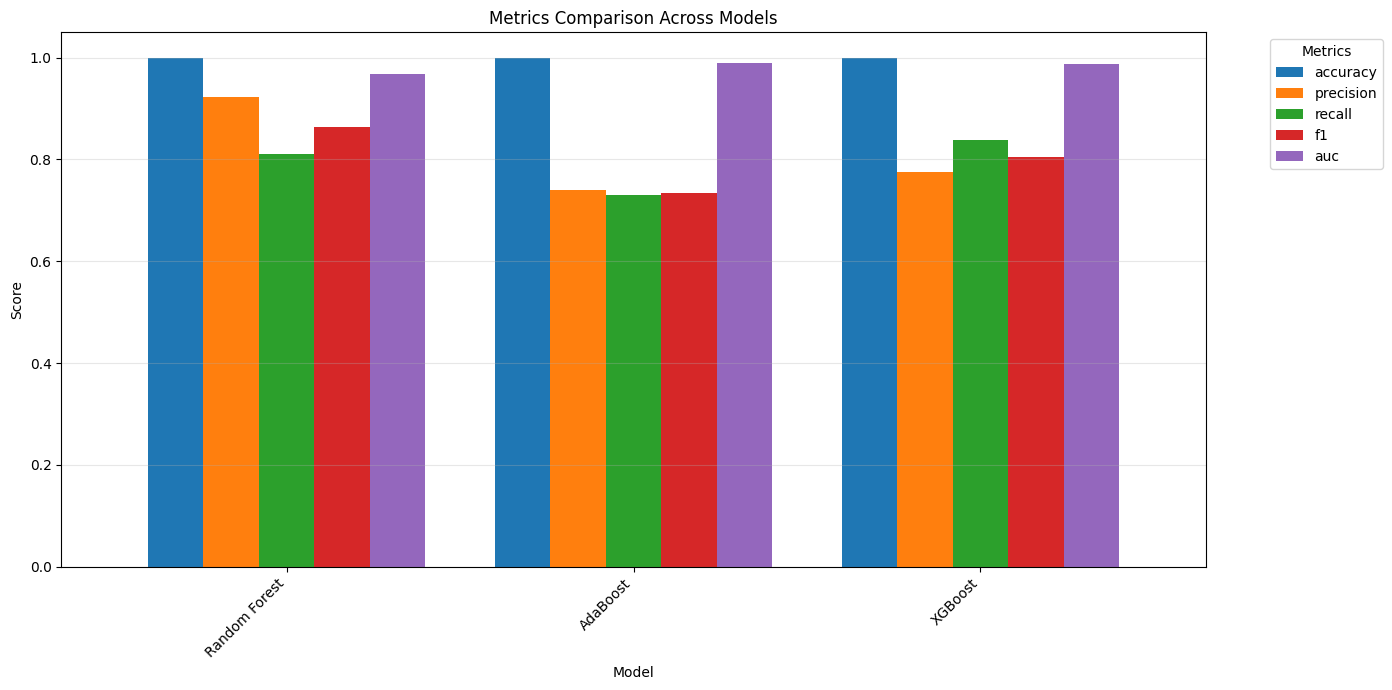

In [16]:
# Plot metrics comparison
from src.evaluate import plot_metrics_comparison

fig = plot_metrics_comparison(all_metrics, figsize=(14, 7))
plt.show()


## 7. Lưu Models đã Train

Lưu tất cả models vào thư mục models/ để sử dụng sau này.


In [17]:
# Save all trained models (chỉ lưu nếu chưa có file)
# Tip: nếu bạn đã chạy notebook 02 trước đó, các model sẽ nằm trong models/ và sẽ được skip train ở bước trên.

# Optionally: lưu thêm Logistic Regression (nếu bạn muốn notebook 03 cũng skip train LR)
if 'lr_model' in globals():
    trained_models.setdefault('Logistic Regression', lr_model)

saved_count = 0
for model_name, model in trained_models.items():
    model_path = _model_path(model_name)
    if model_path.exists():
        print(f"⏭️ Skip save: {model_path.name} already exists")
        continue
    save_model(model, model_name, save_dir=models_dir)
    saved_count += 1

print(f"\n✅ Models directory: {models_dir}")
print(f"✅ Total models in memory: {len(trained_models)}")
print(f"✅ Newly saved this run: {saved_count}")


⏭️ Skip save: random_forest.pkl already exists
⏭️ Skip save: adaboost.pkl already exists
⏭️ Skip save: xgboost.pkl already exists
✅ Model saved to d:\Code\credit_fraud_detection\models\logistic_regression.pkl

✅ Models directory: d:\Code\credit_fraud_detection\models
✅ Total models in memory: 4
✅ Newly saved this run: 1


## 8. Tóm tắt

Tất cả models đã được train, đánh giá và lưu. Kết quả sẽ được sử dụng trong notebook 03 để so sánh và đánh giá cuối cùng.


In [18]:
print("="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"\n✅ Models trained: {len(trained_models)}")
print(f"   - Random Forest")
print(f"   - AdaBoost")
print(f"   - XGBoost")
print(f"\n✅ Models evaluated on validation set: {len(y_val):,} samples")
print(f"✅ Models saved to: {models_dir}")
print(f"\n📊 Next steps:")
print(f"   1. Review metrics comparison above")
print(f"   2. Run notebook 03 for final evaluation and comparison")
print(f"   3. Models are ready for use in fraud_detection_app.py")
print("="*70)


TRAINING SUMMARY

✅ Models trained: 4
   - Random Forest
   - AdaBoost
   - XGBoost

✅ Models evaluated on validation set: 42,721 samples
✅ Models saved to: d:\Code\credit_fraud_detection\models

📊 Next steps:
   1. Review metrics comparison above
   2. Run notebook 03 for final evaluation and comparison
   3. Models are ready for use in fraud_detection_app.py
